In [100]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split

from statsmodels.tsa.vector_ar.var_model import VAR
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import xgboost as xgb

from sktime.performance_metrics.forecasting import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from tabulate import tabulate

# **Wind Farm #1**

In [91]:
DATA_PATH = 'Datasets'

df_wf1 = pd.read_excel(
    os.path.join(DATA_PATH,'Wind farm site 1 (Nominal capacity-99MW).xlsx'), 
)

pd.set_option('display.max_columns', None)
df_wf1

,Time(year-month-day h:m:s),Wind speed at height of 10 meters (m/s),Wind direction at height of 10 meters (˚),Wind speed at height of 30 meters (m/s),Wind direction at height of 30 meters (˚),Wind speed at height of 50 meters (m/s),Wind direction at height of 50 meters (˚),Wind speed - at the height of wheel hub (m/s),Wind speed - at the height of wheel hub (˚),Air temperature (°C),Atmosphere (hpa),Relative humidity (%),Power (MW)
0,2019-01-01 00:00:00,2.209,81.317,1.991,74.814,2.094,77.667,2.494,74.500,-13.484,889.867,76.320,0.254383
1,2019-01-01 00:15:00,1.828,77.460,1.698,75.048,1.757,88.733,1.882,74.367,-13.691,889.575,76.757,0.329703
2,2019-01-01 00:30:00,2.193,86.700,2.313,84.688,2.344,89.100,2.350,89.000,-13.766,889.942,76.981,0.296306
3,2019-01-01 00:45:00,2.654,78.160,2.494,74.939,2.574,87.267,2.808,82.733,-13.691,889.675,76.821,0.187590
4,2019-01-01 01:00:00,2.249,94.297,2.192,91.140,2.558,96.900,2.924,92.967,-13.447,890.025,74.571,0.081005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70171,2020-12-31 22:45:00,5.738,234.600,6.408,235.454,6.575,242.033,6.680,238.433,-9.108,890.008,53.312,13.633642
70172,2020-12-31 23:00:00,5.748,229.333,6.231,233.423,6.372,239.800,6.448,236.833,-9.978,889.817,53.877,6.869759
70173,2020-12-31 23:15:00,4.468,235.133,4.406,253.261,4.381,263.400,4.399,261.733,-9.808,889.825,54.437,4.352931
70174,2020-12-31 23:30:00,3.730,242.580,3.280,252.492,3.204,268.600,3.446,266.733,-9.633,889.492,54.677,7.185250


In [92]:
df_wf1.columns=['time','WS_10','WD_10','WS_30','WD_30','WS_50','WD_50','WS_cen','WD_cen','Air_T','Air_P','Air_H','Power(MW)']

In [93]:
df_wf1.columns = [col.strip() for col in df_wf1.columns]

In [94]:
df_wf1.describe()

,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW)
count,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000
mean,5.711011,222.829748,6.039255,220.633957,6.168763,221.868203,6.375876,216.986224,8.543324,889.527469,37.581143,23.426896
std,3.119512,73.705902,3.700131,79.846922,3.874708,83.092270,3.907965,85.404564,13.368410,2.439019,18.896256,24.130181
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-24.131000,858.400000,1.502000,0.000000
25%,3.538000,209.431500,3.302000,192.871000,3.194000,169.800000,3.300000,144.067000,-3.271000,889.550000,22.355000,1.572839
50%,5.389000,235.987000,5.783000,245.442000,5.811000,251.833000,5.879500,248.825000,9.823000,889.742000,34.401500,14.957783
75%,7.217250,275.287000,8.091000,277.580250,8.384000,281.433000,8.604000,279.304250,19.756000,889.925000,51.584000,40.215230
max,25.465000,358.987000,29.187000,359.087000,29.678000,358.933000,30.247000,358.500000,36.130000,918.192000,93.120000,98.094440


In [95]:
df_wf1[df_wf1['Power(MW)'] == 0.0]

,time,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW)
39247,2020-02-13 19:45:00,3.378,125.700,4.118,111.548,4.456,114.367,4.631,110.267,-1.859,889.567,24.475,0.0
39248,2020-02-13 20:00:00,3.343,128.193,4.602,109.619,4.861,111.433,5.040,105.733,-2.201,890.200,25.381,0.0
39249,2020-02-13 20:15:00,3.448,142.987,4.513,115.724,4.681,116.833,4.736,110.300,-2.814,890.283,25.963,0.0
39250,2020-02-13 20:30:00,3.503,147.780,4.755,117.541,4.727,119.900,4.728,114.000,-2.753,889.583,25.968,0.0
39251,2020-02-13 20:45:00,3.656,139.320,4.862,111.267,5.121,112.900,5.258,108.533,-3.267,890.100,26.437,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57589,2020-08-22 21:15:00,6.288,266.327,7.827,264.050,8.048,268.900,8.369,266.983,22.202,889.400,23.480,0.0
57590,2020-08-22 21:30:00,6.451,260.760,7.705,262.396,8.150,267.700,8.494,264.900,21.460,889.717,24.067,0.0
57591,2020-08-22 21:45:00,5.180,258.653,6.334,259.231,6.924,265.633,7.119,260.400,21.502,889.567,24.744,0.0
57592,2020-08-22 22:00:00,5.211,241.840,6.157,245.209,6.550,253.367,6.766,248.783,21.014,889.550,25.536,0.0


In [96]:
df_wf1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70176 entries, 0 to 70175
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       70176 non-null  object 
 1   WS_10      70176 non-null  float64
 2   WD_10      70176 non-null  float64
 3   WS_30      70176 non-null  float64
 4   WD_30      70176 non-null  float64
 5   WS_50      70176 non-null  float64
 6   WD_50      70176 non-null  float64
 7   WS_cen     70176 non-null  float64
 8   WD_cen     70176 non-null  float64
 9   Air_T      70176 non-null  float64
 10  Air_P      70176 non-null  float64
 11  Air_H      70176 non-null  float64
 12  Power(MW)  70176 non-null  float64
dtypes: float64(12), object(1)
memory usage: 7.0+ MB


In [97]:
df_wf1['time'] = pd.to_datetime(df_wf1['time'], format='%Y-%m-%d %H:%M:%S')

In [98]:
df_wf1.isnull().mean()

time         0.0
WS_10        0.0
WD_10        0.0
WS_30        0.0
WD_30        0.0
WS_50        0.0
WD_50        0.0
WS_cen       0.0
WD_cen       0.0
Air_T        0.0
Air_P        0.0
Air_H        0.0
Power(MW)    0.0
dtype: float64

In [99]:
df_wf1

,time,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW)
0,2019-01-01 00:00:00,2.209,81.317,1.991,74.814,2.094,77.667,2.494,74.500,-13.484,889.867,76.320,0.254383
1,2019-01-01 00:15:00,1.828,77.460,1.698,75.048,1.757,88.733,1.882,74.367,-13.691,889.575,76.757,0.329703
2,2019-01-01 00:30:00,2.193,86.700,2.313,84.688,2.344,89.100,2.350,89.000,-13.766,889.942,76.981,0.296306
3,2019-01-01 00:45:00,2.654,78.160,2.494,74.939,2.574,87.267,2.808,82.733,-13.691,889.675,76.821,0.187590
4,2019-01-01 01:00:00,2.249,94.297,2.192,91.140,2.558,96.900,2.924,92.967,-13.447,890.025,74.571,0.081005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70171,2020-12-31 22:45:00,5.738,234.600,6.408,235.454,6.575,242.033,6.680,238.433,-9.108,890.008,53.312,13.633642
70172,2020-12-31 23:00:00,5.748,229.333,6.231,233.423,6.372,239.800,6.448,236.833,-9.978,889.817,53.877,6.869759
70173,2020-12-31 23:15:00,4.468,235.133,4.406,253.261,4.381,263.400,4.399,261.733,-9.808,889.825,54.437,4.352931
70174,2020-12-31 23:30:00,3.730,242.580,3.280,252.492,3.204,268.600,3.446,266.733,-9.633,889.492,54.677,7.185250


Power(MW) column deals with 0.0 values, hence we will remove these rows to have realistic MAPE calculations.

In [101]:
#df_wf1_filtered = df_wf1[df_wf1['Power(MW)'] != 0.0]
df_wf1_filtered = df_wf1

## **Pairplots**

In [102]:
#sns.pairplot(df_wf1, hue=None, size=2.5)

## **Correlation matrix**

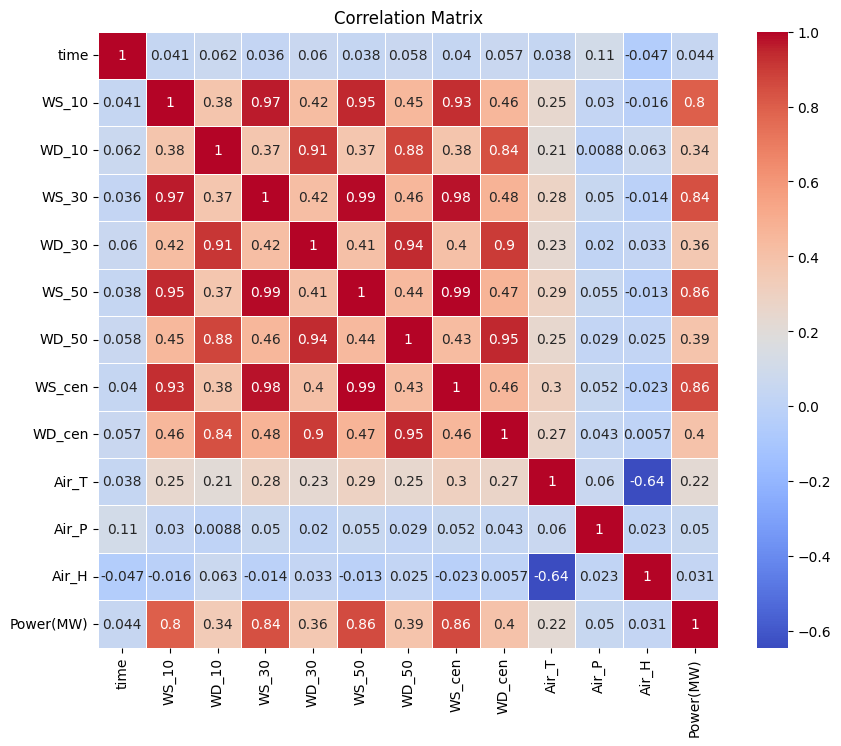

In [103]:
correlation_matrix = df_wf1.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [104]:
pearsonr(df_wf1['WS_10'], df_wf1['Power(MW)'])

PearsonRResult(statistic=0.7998595044473422, pvalue=0.0)

In [105]:
pearsonr(df_wf1['WS_30'], df_wf1['Power(MW)'])

PearsonRResult(statistic=0.8399594587604483, pvalue=0.0)

In [106]:
pearsonr(df_wf1['WS_50'], df_wf1['Power(MW)'])

PearsonRResult(statistic=0.8563136119964403, pvalue=0.0)

In [107]:
pearsonr(df_wf1['WS_cen'], df_wf1['Power(MW)'])

PearsonRResult(statistic=0.8617302465680093, pvalue=0.0)

With respect to the target variable [Power (MW)], the 4 below features have high correlations on top of very significant pvalues:
- 0.8 with Wind speed at height of 10 meters (m/s)
- 0.84 with Wind speed at height of 30 meters (m/s)
- 0.86 with Wind speed at height of 50 meters (m/s)
- 0.86 with Wind speed - at the height of wheel hub (m/s)

In [108]:
df_wf1_filtered.set_index('time', inplace=True)

In [109]:
df_wf1_filtered

,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW)
time,,,,,,,,,,,,
2019-01-01 00:00:00,2.209,81.317,1.991,74.814,2.094,77.667,2.494,74.500,-13.484,889.867,76.320,0.254383
2019-01-01 00:15:00,1.828,77.460,1.698,75.048,1.757,88.733,1.882,74.367,-13.691,889.575,76.757,0.329703
2019-01-01 00:30:00,2.193,86.700,2.313,84.688,2.344,89.100,2.350,89.000,-13.766,889.942,76.981,0.296306
2019-01-01 00:45:00,2.654,78.160,2.494,74.939,2.574,87.267,2.808,82.733,-13.691,889.675,76.821,0.187590
2019-01-01 01:00:00,2.249,94.297,2.192,91.140,2.558,96.900,2.924,92.967,-13.447,890.025,74.571,0.081005
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 22:45:00,5.738,234.600,6.408,235.454,6.575,242.033,6.680,238.433,-9.108,890.008,53.312,13.633642
2020-12-31 23:00:00,5.748,229.333,6.231,233.423,6.372,239.800,6.448,236.833,-9.978,889.817,53.877,6.869759
2020-12-31 23:15:00,4.468,235.133,4.406,253.261,4.381,263.400,4.399,261.733,-9.808,889.825,54.437,4.352931


In [110]:
df_wf1_filtered=df_wf1_filtered.asfreq('15T')
print(df_wf1_filtered.index.freq)

<15 * Minutes>


## **Preparing training, testing and demo datasets**

We will slip the entire .csv file into three subdatasets:

- **Modeling**
1. Training (to input training data into forecasting models)
2. Testing (to test forecasting models comparing forcasting with testing data)

- **Demo**
3. Historical (to refit the training+testing with real data after each user forecast request; 1 month of data)

In [111]:
one_month_range = df_wf1_filtered.index.max() - pd.DateOffset(months=1)
df_demo = df_wf1_filtered[df_wf1_filtered.index >= one_month_range]

df_wf1_model = df_wf1_filtered[df_wf1_filtered.index < one_month_range]

df_wf1_train, df_wf1_test = train_test_split(df_wf1_model, train_size = 0.7, test_size = 0.3, shuffle=False)

In [112]:
y_train = df_wf1_train[['Power(MW)']]
X_train = df_wf1_train[['WS_10', 'WD_10', 'WS_30', 'WD_30', 'WS_50', 'WD_50', 'WS_cen',	'WD_cen', 'Air_T', 'Air_P', 'Air_H']]

In [113]:
y_test = df_wf1_test[['Power(MW)']]
X_test = df_wf1_test[['WS_10', 'WD_10', 'WS_30', 'WD_30', 'WS_50', 'WD_50', 'WS_cen',	'WD_cen', 'Air_T', 'Air_P', 'Air_H']]

In [114]:
X_train

,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H
time,,,,,,,,,,,
2019-01-01 00:00:00,2.209,81.317,1.991,74.814,2.094,77.667,2.494,74.500,-13.484,889.867,76.320
2019-01-01 00:15:00,1.828,77.460,1.698,75.048,1.757,88.733,1.882,74.367,-13.691,889.575,76.757
2019-01-01 00:30:00,2.193,86.700,2.313,84.688,2.344,89.100,2.350,89.000,-13.766,889.942,76.981
2019-01-01 00:45:00,2.654,78.160,2.494,74.939,2.574,87.267,2.808,82.733,-13.691,889.675,76.821
2019-01-01 01:00:00,2.249,94.297,2.192,91.140,2.558,96.900,2.924,92.967,-13.447,890.025,74.571
...,...,...,...,...,...,...,...,...,...,...,...
2020-05-04 22:30:00,7.618,315.093,8.657,310.847,9.134,316.900,9.594,316.800,19.714,889.817,21.776
2020-05-04 22:45:00,7.304,300.200,8.206,301.303,8.716,309.200,9.374,306.700,19.602,890.033,22.317
2020-05-04 23:00:00,7.075,296.200,7.925,296.618,8.344,302.767,8.752,302.500,19.502,889.967,23.181


In [115]:
print(df_wf1_filtered.index.freq)

<15 * Minutes>


## **Reductions - Random Forest (TEST)**

In [116]:
from sktime.forecasting.compose import make_reduction
from sklearn.ensemble import RandomForestRegressor

estimator = RandomForestRegressor(bootstrap=True, n_estimators=100, random_state=42)

forecaster = make_reduction(estimator, strategy='recursive', window_length=10)

horizon = list(range(1, len(y_test) + 1))

forecaster.fit(y_train, X=X_train)
predictions_reductions = forecaster.predict(fh=horizon, X=X_test)

print(predictions_reductions)

                     Power(MW)
2020-05-04 23:45:00  23.870492
2020-05-05 00:00:00  24.400369
2020-05-05 00:15:00  23.123203
2020-05-05 00:30:00  23.234201
2020-05-05 00:45:00  23.388884
...                        ...
2020-11-30 22:30:00  33.908958
2020-11-30 22:45:00  31.216628
2020-11-30 23:00:00  30.231563
2020-11-30 23:15:00  30.721328
2020-11-30 23:30:00  31.068603

[20160 rows x 1 columns]


In [152]:
mae_reductions = mean_absolute_error(y_test, predictions_reductions)
print("Mean Absolute Error (MAE):", mae_reductions)

mse_reductions = mean_squared_error(y_test, predictions_reductions)
print("Mean Squared Error (MSE):", mse_reductions)

r2_reductions = r2_score(y_test, predictions_reductions)
print("R-squared (R2) Score:", r2_reductions)

mape_reductions = mean_absolute_percentage_error(y_test, predictions_reductions)
print("Mean Absolute Percentage Error (MAPE):", mape_reductions)

Mean Absolute Error (MAE): 23.8763593676751
Mean Squared Error (MSE): 778.9939747515052
R-squared (R2) Score: -0.16953154080554111
Mean Absolute Percentage Error (MAPE): 1649340722671179.2


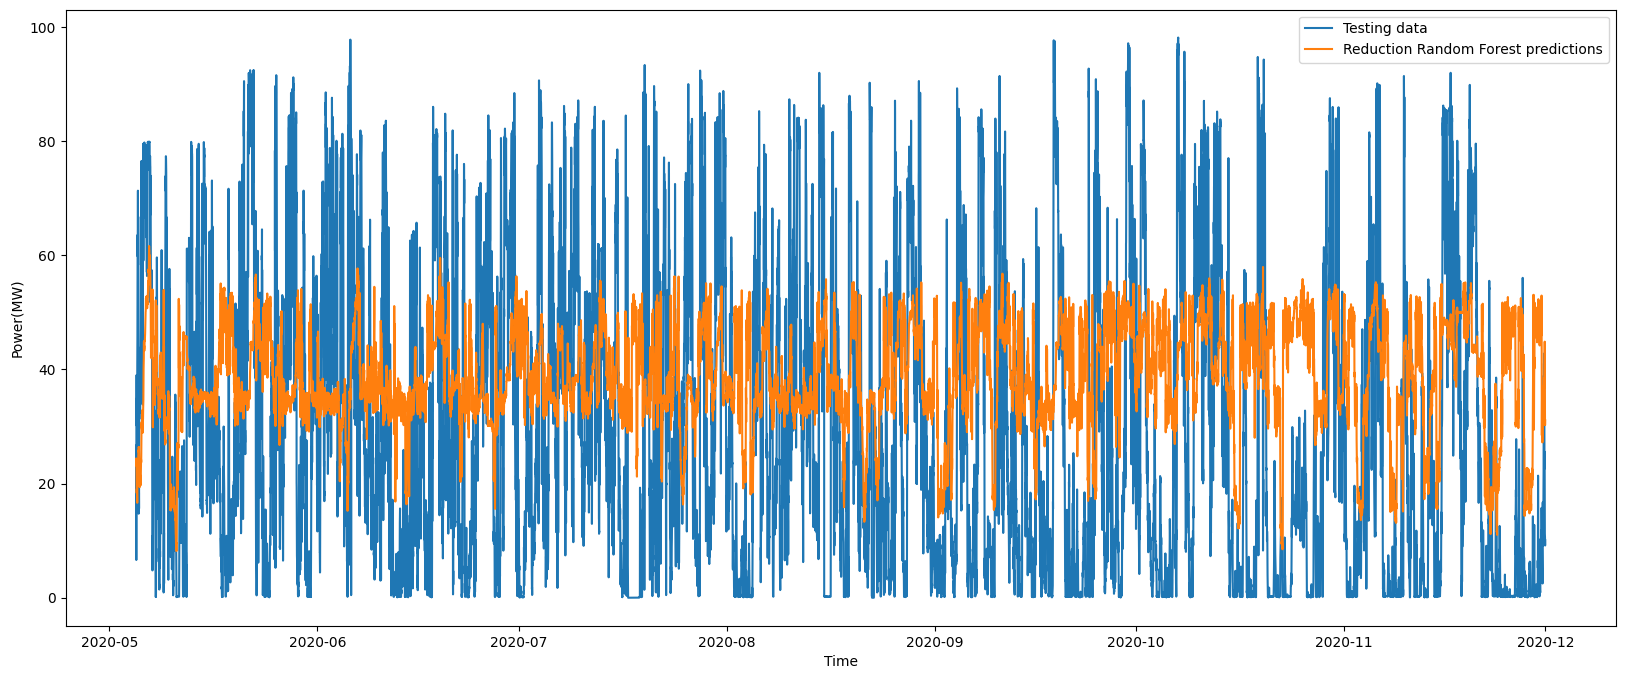

In [153]:
plt.figure(figsize=(20, 8))
plt.plot(y_test, label='Testing data')
plt.plot(predictions_reductions, label='Reduction Random Forest predictions')
plt.xlabel('Time')
plt.ylabel('Power(MW)')
plt.legend()
plt.show()

## **OLS - Ordinary Least Squares**

In [117]:
lm = LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(estimator=lm, n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

In [118]:
rfe.support_

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [119]:
X_train.columns[rfe.support_]

Index(['WS_10', 'WS_30', 'WD_30', 'WS_50', 'WD_50', 'WS_cen', 'WD_cen',
       'Air_T', 'Air_P', 'Air_H'],
      dtype='object')

In [120]:
X_train_rfe = X_train[X_train.columns[rfe.support_]]
X_train_rfe.head()

,WS_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H
time,,,,,,,,,,
2019-01-01 00:00:00,2.209,1.991,74.814,2.094,77.667,2.494,74.500,-13.484,889.867,76.320
2019-01-01 00:15:00,1.828,1.698,75.048,1.757,88.733,1.882,74.367,-13.691,889.575,76.757
2019-01-01 00:30:00,2.193,2.313,84.688,2.344,89.100,2.350,89.000,-13.766,889.942,76.981
2019-01-01 00:45:00,2.654,2.494,74.939,2.574,87.267,2.808,82.733,-13.691,889.675,76.821
2019-01-01 01:00:00,2.249,2.192,91.140,2.558,96.900,2.924,92.967,-13.447,890.025,74.571


In [121]:
def build_model(X,y):
    X = sm.add_constant(X) #Adding the constant
    lm = sm.OLS(y,X).fit() # fitting the model
    print(lm.summary()) # model summary
    return X
    
def checkVIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

In [122]:
X_train_new = build_model(X_train_rfe,y_train)

                            OLS Regression Results                            
Dep. Variable:              Power(MW)   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                 1.476e+04
Date:                Tue, 09 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:01:52   Log-Likelihood:            -1.8085e+05
No. Observations:               47039   AIC:                         3.617e+05
Df Residuals:                   47028   BIC:                         3.618e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -69.5824     16.084     -4.326      0.0

In [123]:
checkVIF(X_train_new)

,Features,VIF
0,const,95087.54
4,WS_50,344.00
2,WS_30,156.44
6,WS_cen,122.00
1,WS_10,19.16
5,WD_50,15.48
7,WD_cen,10.06
3,WD_30,8.70
8,Air_T,2.14
10,Air_H,1.89


In [124]:
X_train_new = X_train_new.drop(["WS_50"], axis = 1)
checkVIF(X_train_new)

,Features,VIF
0,const,94862.12
2,WS_30,49.78
5,WS_cen,24.34
1,WS_10,16.48
4,WD_50,15.47
6,WD_cen,10.04
3,WD_30,8.64
7,Air_T,2.13
9,Air_H,1.89
8,Air_P,1.02


In [125]:
X_train_new = X_train_new.drop(["WS_30"], axis = 1)
checkVIF(X_train_new)

,Features,VIF
0,const,94575.75
3,WD_50,15.35
5,WD_cen,9.92
2,WD_30,8.28
4,WS_cen,7.83
1,WS_10,7.60
6,Air_T,2.12
8,Air_H,1.89
7,Air_P,1.02


In [126]:
X_train_new = X_train_new.drop(["WD_50"], axis = 1)
checkVIF(X_train_new)

,Features,VIF
0,const,94562.36
3,WS_cen,7.80
1,WS_10,7.56
4,WD_cen,5.46
2,WD_30,5.21
5,Air_T,2.12
7,Air_H,1.89
6,Air_P,1.02


In [127]:
X_train_new = X_train_new.drop(["WS_cen"], axis = 1)
checkVIF(X_train_new)

,Features,VIF
0,const,94335.51
3,WD_cen,5.37
2,WD_30,5.12
4,Air_T,2.01
6,Air_H,1.85
1,WS_10,1.30
5,Air_P,1.02


In [128]:
X_train_new = build_model(X_train_new,y_train)

                            OLS Regression Results                            
Dep. Variable:              Power(MW)   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                 1.428e+04
Date:                Tue, 09 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:01:53   Log-Likelihood:            -1.8986e+05
No. Observations:               47039   AIC:                         3.797e+05
Df Residuals:                   47032   BIC:                         3.798e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -185.9376     19.400     -9.584      0.0

In [129]:
lm = sm.OLS(y_train,X_train_new).fit()
y_train = lm.predict(X_train_new)

In [130]:
num_vars = ['WS_10', 'WD_30', 'WD_cen', 'Air_T', 'Air_P', 'Air_H']
X_test_new = df_wf1_test[num_vars]

In [131]:
# Now let's use our model to make predictions.
X_train_new = X_train_new.drop('const',axis=1)
# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [132]:
# Making predictions
predictions_ols = lm.predict(X_test_new)

Text(0, 0.5, 'y_pred')

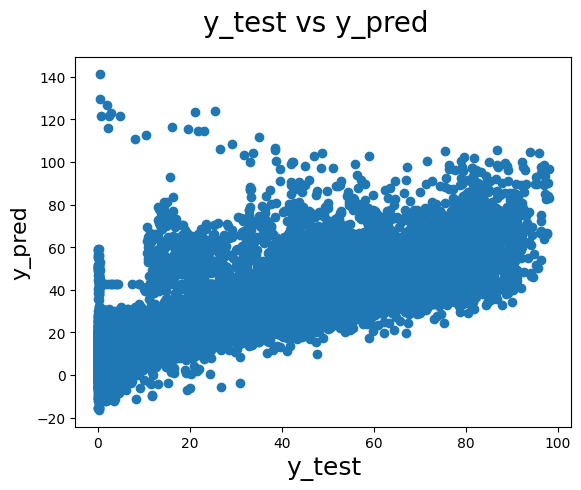

In [133]:
#EVALUATION OF THE MODEL
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,predictions_ols)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)   

In [134]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              Power(MW)   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                 1.428e+04
Date:                Tue, 09 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:01:54   Log-Likelihood:            -1.8986e+05
No. Observations:               47039   AIC:                         3.797e+05
Df Residuals:                   47032   BIC:                         3.798e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -185.9376     19.400     -9.584      0.0

R-squared = 0.648, which is less than 0.8; typically the threshold value required to retain a model built with OLS.

In [135]:
mae_ols = mean_absolute_error(y_test, predictions_ols)
print("Mean Absolute Error (MAE):", mae_ols)

mse_ols = mean_squared_error(y_test, predictions_ols)
print("Mean Squared Error (MSE):", mse_ols)

r2_ols = r2_score(y_test, predictions_ols)
print("R-squared (R2) Score:", r2_ols)

mape_ols = mean_absolute_percentage_error(y_test, predictions_ols)
print("Mean Absolute Percentage Error (MAPE):", mape_ols)

Mean Absolute Error (MAE): 11.534207354066146
Mean Squared Error (MSE): 242.31048102681413
R-squared (R2) Score: 0.6362106005774671
Mean Absolute Percentage Error (MAPE): 666075082251469.9


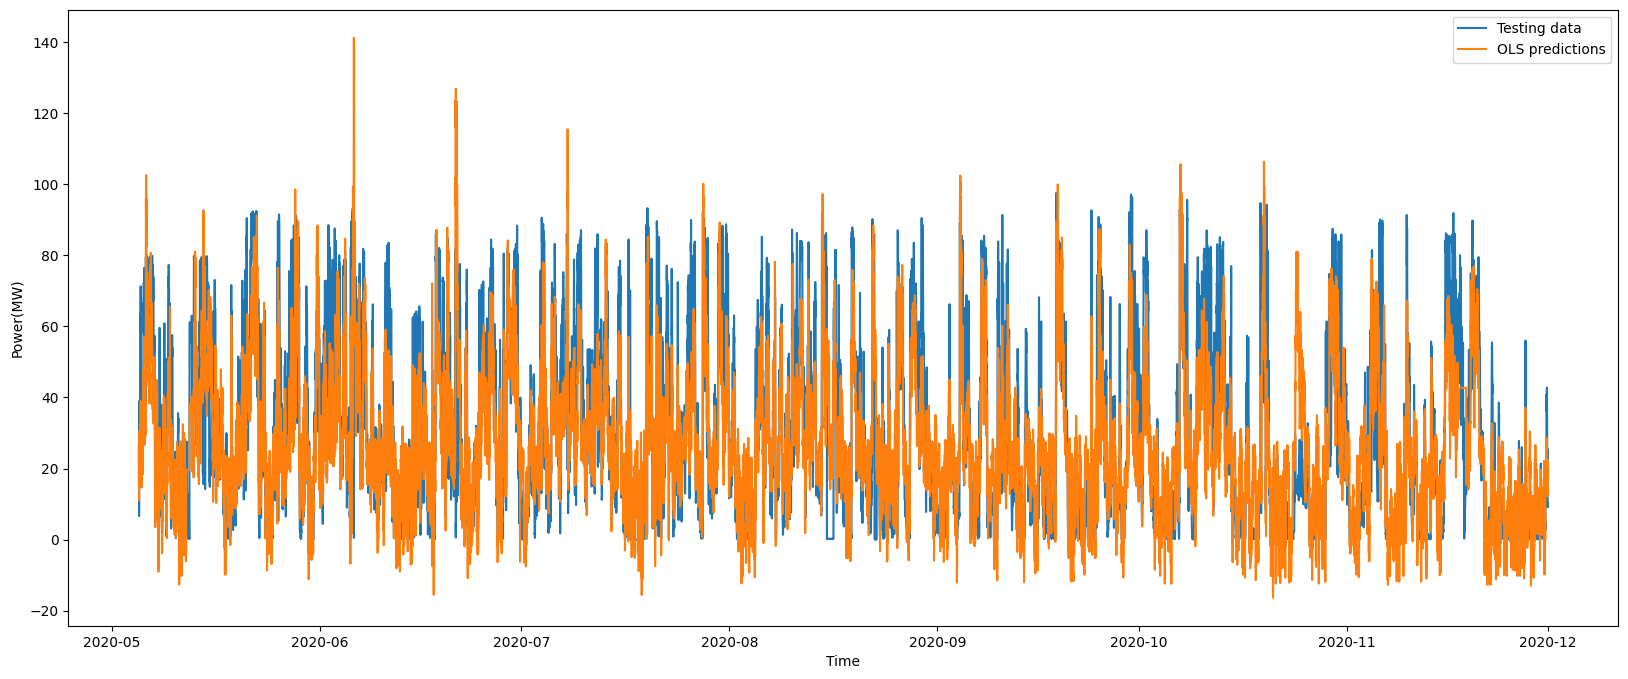

In [136]:
plt.figure(figsize=(20, 8))
plt.plot(y_test, label='Testing data')
plt.plot(predictions_ols, label='OLS predictions')
plt.xlabel('Time')
plt.ylabel('Power(MW)')
plt.legend()
plt.show()

## **LSTM - Long short-term memory**

In [137]:
X_train_lstm = X_train.values
X_test_lstm = X_test.values

X_train_lstm = X_train_lstm.reshape(X_train.shape[0], 1, X_train_lstm.shape[1])
X_test_lstm = X_test_lstm.reshape(X_test.shape[0], 1, X_test_lstm.shape[1])

model_lstm = Sequential()
model_lstm.add(LSTM(units=50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

model_lstm.fit(X_train_lstm, y_train, epochs=100, batch_size=50, verbose=1)

predictions = model_lstm.predict(X_test_lstm)
predictions_lstm = pd.DataFrame(predictions, index=y_test.index, columns=['Predicted Power(MW)'])

C:\Users\mattd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
941/941 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 675.0602
Epoch 2/100
941/941 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 410.8963
Epoch 3/100
941/941 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 255.5084
Epoch 4/100
941/941 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 165.4762
Epoch 5/100
941/941 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 111.4158
Epoch 6/100
941/941 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 69.9684
Epoch 7/100
941/941 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 46.3936
Epoch 8/100
941/941 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 31.2399
Epoch 9/100
941/941 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 20.5279
Epoch 10/100
941/941 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 14.7420
Epoch 11/100
941/941 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 10.1803
Epoch 12/100
941/941 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.9916
Epoch 13/100
941/941 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 6.5606
Epoch 14/100
941/941 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.4313
Epoch 15/100
941/941 ━━━━━━

In [138]:
mae_lstm = mean_absolute_error(y_test, predictions_lstm)
print("Mean Absolute Error (MAE):", mae_lstm)

mse_lstm = mean_squared_error(y_test, predictions_lstm)
print("Mean Squared Error (MSE):", mse_lstm)

r2_lstm = r2_score(y_test, predictions_lstm)
print("R-squared (R2) Score:", r2_lstm)

mape_lstm = mean_absolute_percentage_error(y_test, predictions_lstm)
print("Mean Absolute Percentage Error (MAPE):", mape_lstm)

Mean Absolute Error (MAE): 11.442925134159761
Mean Squared Error (MSE): 234.85797645147744
R-squared (R2) Score: 0.6473993124819901
Mean Absolute Percentage Error (MAPE): 674857570843793.6


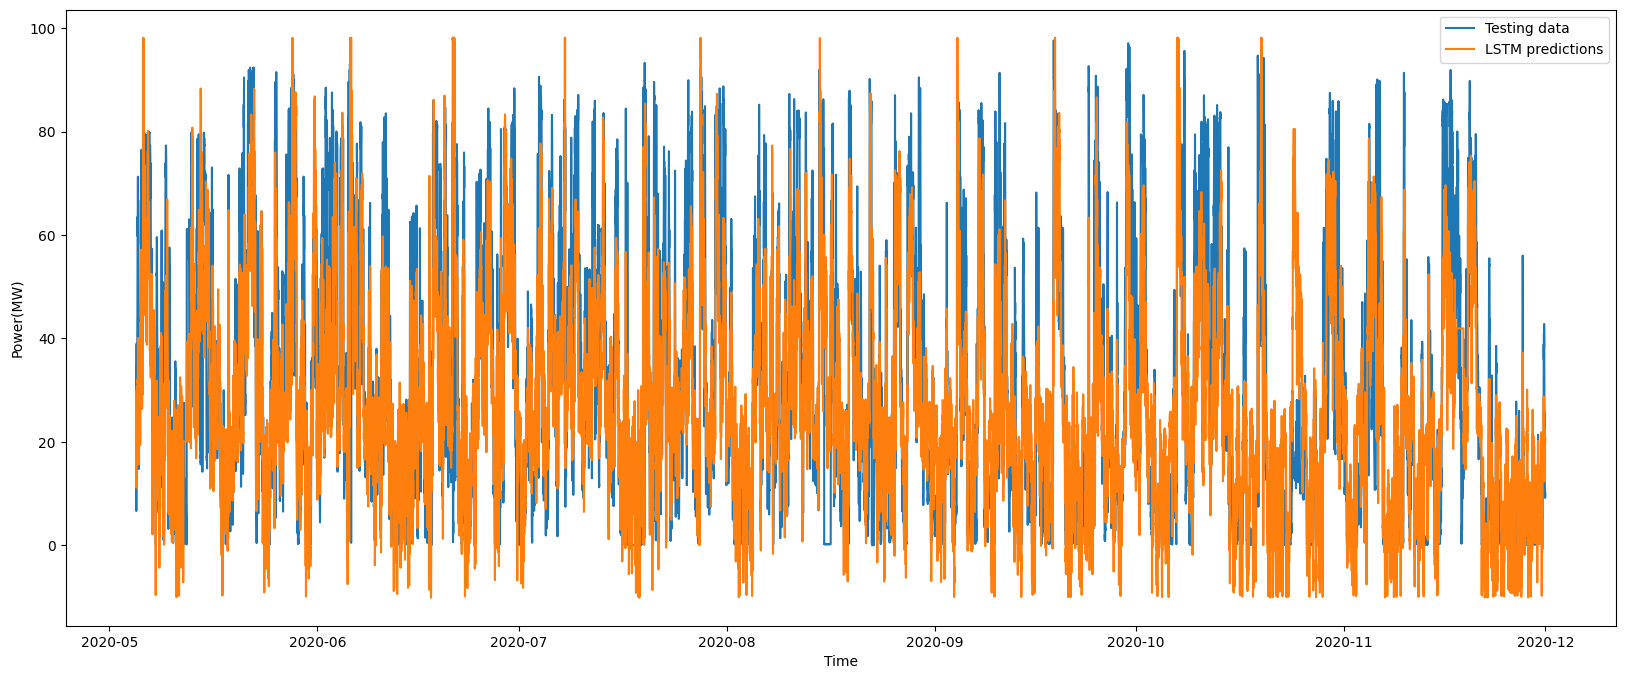

In [139]:
plt.figure(figsize=(20, 8))
plt.plot(y_test, label='Testing data')
plt.plot(predictions_lstm, label='LSTM predictions')
plt.xlabel('Time')
plt.ylabel('Power(MW)')
plt.legend()
plt.show()

## **Random Forest model**

In [140]:
randomforest_regressor = RandomForestRegressor(bootstrap=True, n_estimators=100, random_state=42)

randomforest_regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [141]:
predictions = randomforest_regressor.predict(X_test)
predictions_randomforest = pd.DataFrame(predictions, index=y_test.index, columns=['Predicted Power(MW)'])

In [142]:
mae_randomforest = mean_absolute_error(y_test, predictions_randomforest)
print("Mean Absolute Error (MAE):", mae_randomforest)

mse_randomforest = mean_squared_error(y_test, predictions_randomforest)
print("Mean Squared Error (MSE):", mse_randomforest)

r2_randomforest = r2_score(y_test, predictions_randomforest)
print("R-squared (R2) Score:", r2_randomforest)

mape_randomforest = mean_absolute_percentage_error(y_test, predictions_randomforest)
print("Mean Absolute Percentage Error (MAPE):", mape_randomforest)

Mean Absolute Error (MAE): 11.529687323953944
Mean Squared Error (MSE): 242.01400923998605
R-squared (R2) Score: 0.6366557042841614
Mean Absolute Percentage Error (MAPE): 663938345724044.2


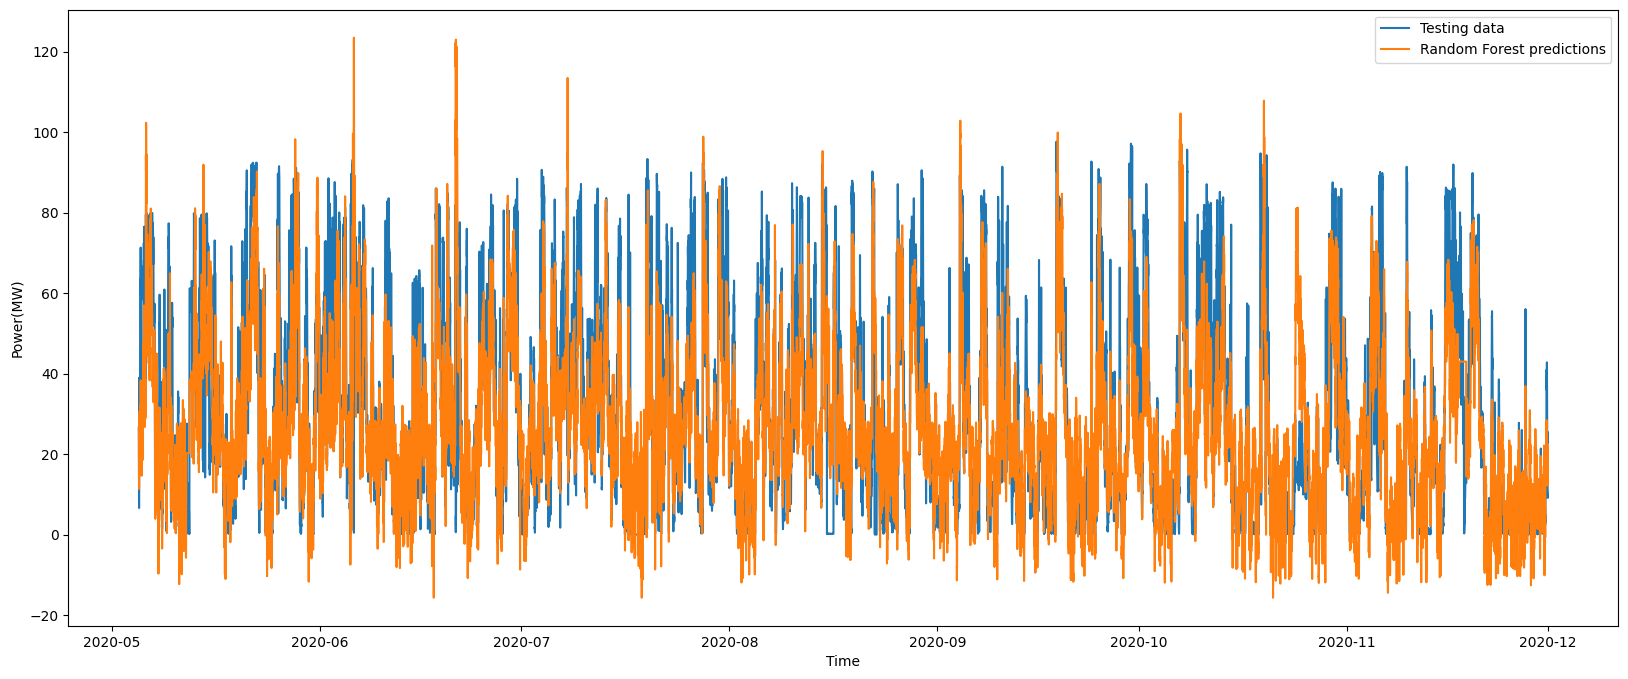

In [143]:
plt.figure(figsize=(20, 8))
plt.plot(y_test, label='Testing data')
plt.plot(predictions_randomforest, label='Random Forest predictions')
plt.xlabel('Time')
plt.ylabel('Power(MW)')
plt.legend()
plt.show()

## **XGBoost model**

In [144]:
xgboost_model = xgb.XGBRegressor(max_depth=3, learning_rate=0.05, n_estimators=75)
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=75, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [145]:
predictions = xgboost_model.predict(X_test)
predictions_xgboost = pd.DataFrame(predictions, index=y_test.index, columns=['Predicted Power(MW)'])

In [146]:
mae_xgboost = mean_absolute_error(y_test, predictions_xgboost)
print("Mean Absolute Error (MAE):", mae_xgboost)

mse_xgboost = mean_squared_error(y_test, predictions_xgboost)
print("Mean Squared Error (MSE):", mse_xgboost)

r2_xgboost = r2_score(y_test, predictions_xgboost)
print("R-squared (R2) Score:", r2_xgboost)

mape_xgboost = mean_absolute_percentage_error(y_test, predictions_xgboost)
print("Mean Absolute Percentage Error (MAPE):", mape_xgboost)

Mean Absolute Error (MAE): 11.552200906650508
Mean Squared Error (MSE): 239.40230913574888
R-squared (R2) Score: 0.6405767431445774
Mean Absolute Percentage Error (MAPE): 639060008014414.9


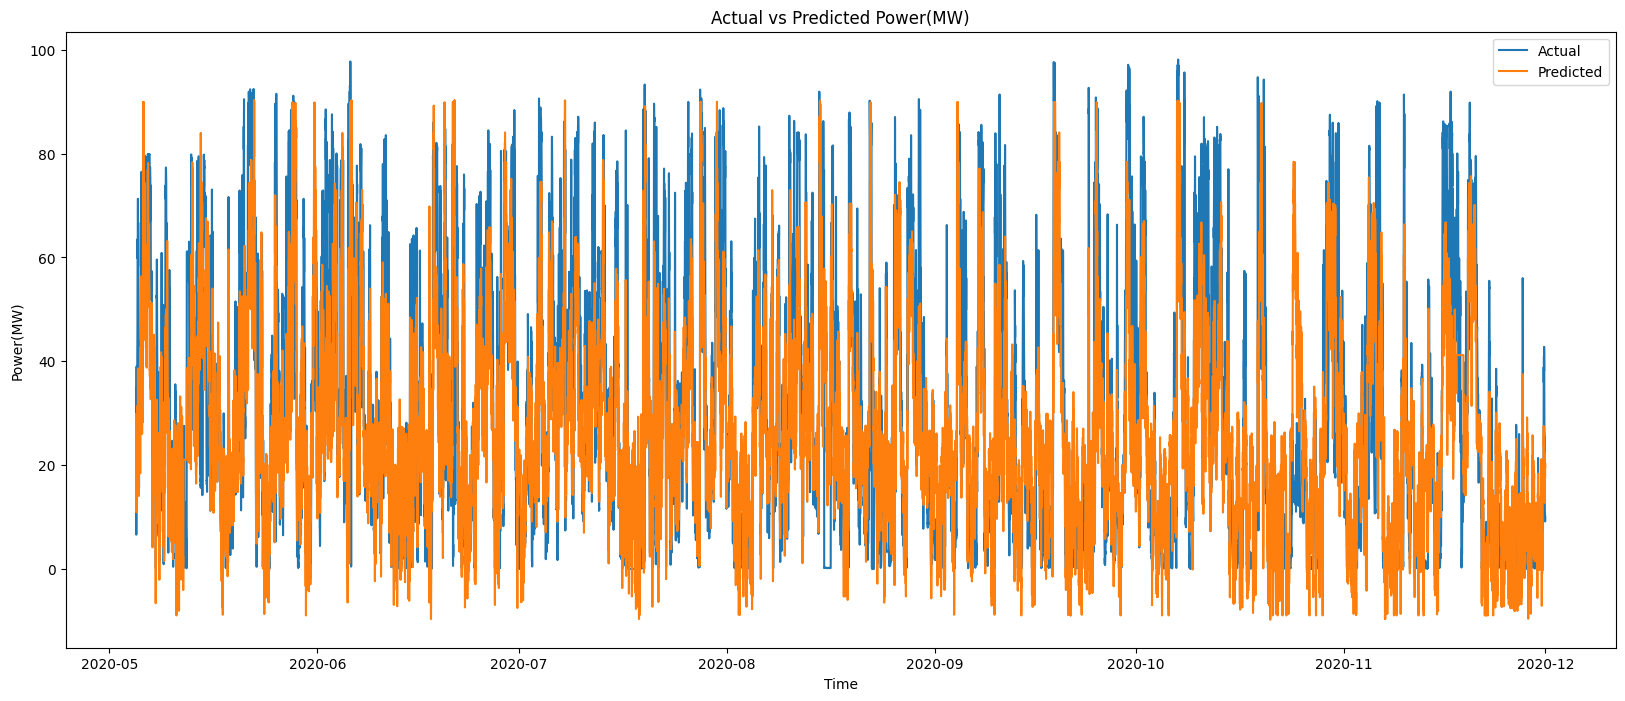

In [147]:
plt.figure(figsize=(20, 8))
plt.plot(y_test, label='Actual')
plt.plot(predictions_xgboost, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Power(MW)')
plt.title('Actual vs Predicted Power(MW)')
plt.legend()
plt.show()

## **XGBoost with 6h refit model (test)**

In [148]:
import xgboost as xgb
import pandas as pd

dtrain = xgb.DMatrix(X_train, label=y_train)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
}

initial_model = xgb.train(params, dtrain, num_boost_round=75)  # You can adjust num_boost_round as needed
predictions = initial_model.predict(xgb.DMatrix(X_test))
predictions_xgboost = pd.DataFrame(predictions, index=y_test.index, columns=['Predicted Power(MW)'])

"""
Historical data to be included into the model
and retraining of the model with that historical data

"""


end_time = df_demo.index[0] + pd.Timedelta(hours=6)
df_historical_data = df_demo.loc[df_demo.index[0]:end_time]

y_historical = df_historical_data[['Power(MW)']]
X_historical = df_historical_data[['WS_10', 'WD_10', 'WS_30', 'WD_30', 'WS_50', 'WD_50', 'WS_cen', 'WD_cen', 'Air_T', 'Air_P', 'Air_H']]

dtrain_historical = xgb.DMatrix(X_historical, label=y_historical)

updated_model = xgb.train(params, dtrain_historical, num_boost_round=10, xgb_model=initial_model)

"""
Newest predictions (including the historical data into the model)
"""

df_new_training = df_wf1_model.iloc[-46895:]
X_last_points = df_new_training.drop(columns=['Power(MW)'])

updated_preds = updated_model.predict(xgb.DMatrix(X_last_points))

predictions_6h_refit_xgboost = pd.DataFrame(updated_preds, index=df_new_training.index, columns=['Predicted Power(MW)'])

In [149]:
predictions_xgboost

,Predicted Power(MW)
time,
2020-05-04 23:45:00,26.371847
2020-05-05 00:00:00,23.114418
2020-05-05 00:15:00,16.057775
2020-05-05 00:30:00,11.170405
2020-05-05 00:45:00,20.842495
...,...
2020-11-30 22:30:00,16.773384
2020-11-30 22:45:00,18.725180
2020-11-30 23:00:00,18.020699


In [150]:
predictions_6h_refit_xgboost

,Predicted Power(MW)
time,
2019-07-31 12:00:00,22.552792
2019-07-31 12:15:00,25.850719
2019-07-31 12:30:00,29.457382
2019-07-31 12:45:00,29.839016
2019-07-31 13:00:00,32.630486
...,...
2020-11-30 22:30:00,14.234298
2020-11-30 22:45:00,16.186090
2020-11-30 23:00:00,15.481610


## **Gradient Boosting model**

## **Summary**

In [154]:
models = ["OLS ('WS_10', 'WD_30', 'WD_cen', 'Air_T', 'Air_P', 'Air_H')", "LSTM (epochs=100, batch_size=50)", "Random Forest (n_estimators=100, random_state=42)", "XGBoost (max_depth=3, learning_rate=0.1, n_estimators=150)", "Reduction with Random Forest (n_estimators=100, random_state=42)"]
metrics = ["Mean Absolute Error (MAE)", "Mean Squarred Error (MSE)", "R-squared (R2) Score", "Mean Absolute Percentage Error (MAPE)"]
values_mae = [mae_ols, mae_lstm, mae_randomforest, mae_xgboost, mae_reductions]
values_mse = [mse_ols, mse_lstm, mse_randomforest, mse_xgboost, mse_reductions]
values_r2 = [r2_ols, r2_lstm, r2_randomforest, r2_xgboost, r2_reductions]
values_mape = [mape_ols, mape_lstm, mape_randomforest, mape_xgboost, mape_reductions]

table_data = [
    [model, mae, mse, r2, mape] for model, mae, mse, r2, mape in zip(models, values_mae, values_mse, values_r2, values_mape)
]

print(tabulate(table_data, headers=["Model", "Mean Absolute Error (MAE)", "Mean Squarred Error (MSE)", "R-squared (R2) Score", "Mean Absolute Percentage Error (MAPE)"], tablefmt="grid"))

+------------------------------------------------------------------+-----------------------------+-----------------------------+------------------------+-----------------------------------------+
| Model                                                            |   Mean Absolute Error (MAE) |   Mean Squarred Error (MSE) |   R-squared (R2) Score |   Mean Absolute Percentage Error (MAPE) |
+==================================================================+=============================+=============================+========================+=========================================+
| OLS ('WS_10', 'WD_30', 'WD_cen', 'Air_T', 'Air_P', 'Air_H')      |                     11.5342 |                     242.31  |               0.636211 |                             6.66075e+14 |
+------------------------------------------------------------------+-----------------------------+-----------------------------+------------------------+-----------------------------------------+
| LSTM (epochs=100, 

## **Backtesting**

In [ ]:
#model_lstm.update(df_wf1_test)

AttributeError: 'Sequential' object has no attribute 'update'